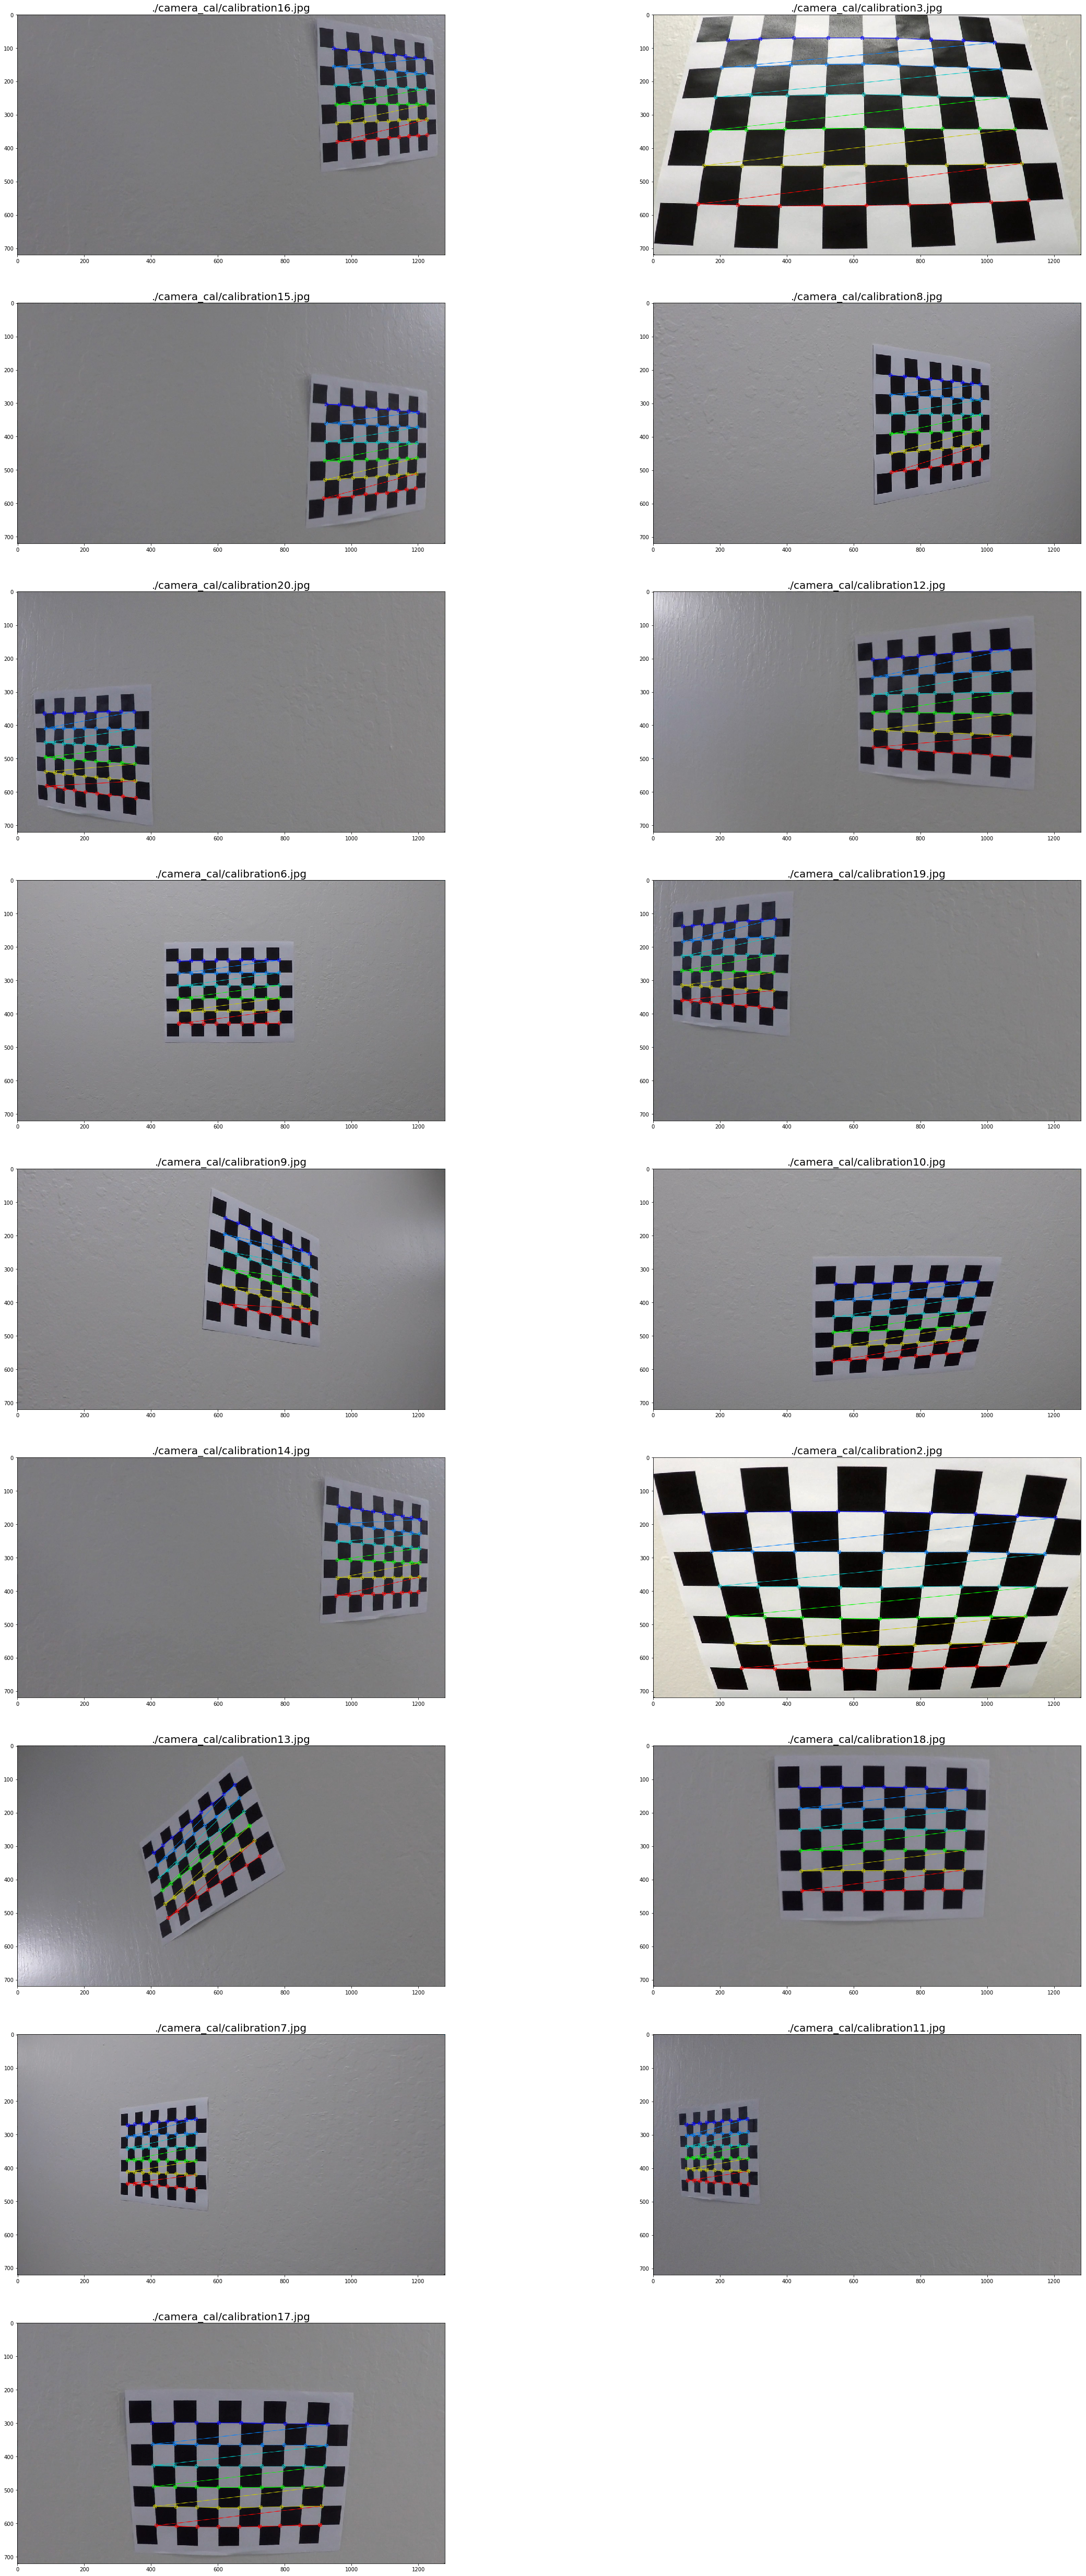

In [6]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import glob 
import matplotlib.pyplot as plt
import unittest
import os

from moviepy.editor import VideoFileClip

%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
index = 1
plt.figure(figsize=(40,100))
img_size=(0,0)

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_size = (img.shape[1], img.shape[0])
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

        ax = plt.subplot(10,2, index)
        ax.imshow(img)

        ax.set_title(fname, fontsize=20)
        index+=1



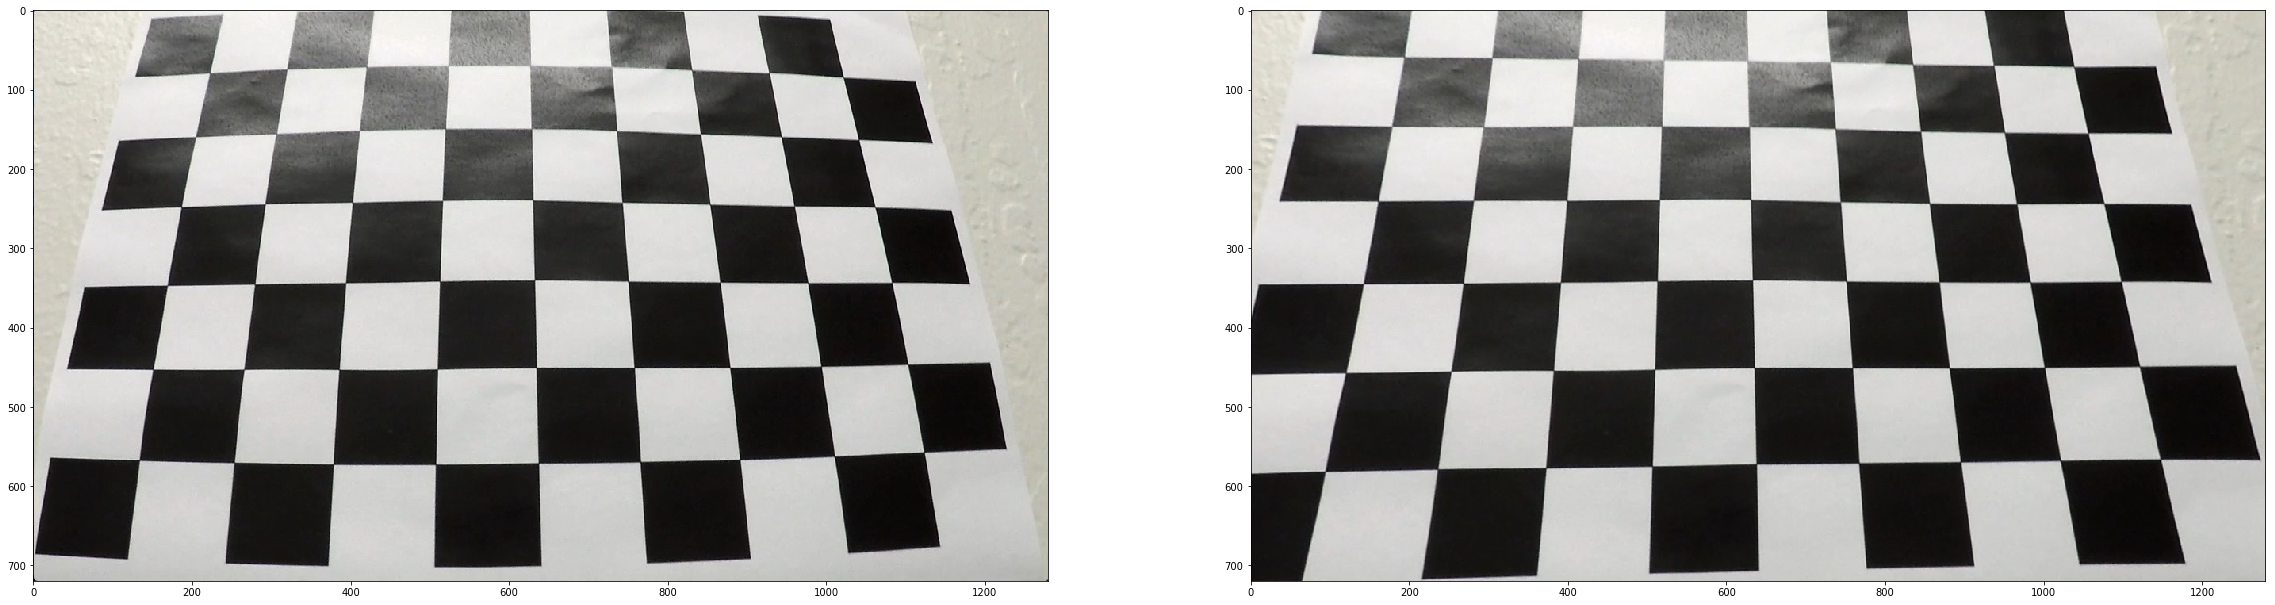

In [11]:


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
                         objpoints,
                         imgpoints,
                         img_size,None,None) 

img = mpimg.imread("./camera_cal/calibration3.jpg")
plt.figure(figsize=(40,20))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(cv2.undistort(img, mtx, dist, None, mtx))
plt.savefig('camera_cal_output.png')

In [3]:
class Camerapipe:
  window_width = 50 
  window_height = 80 # Break image into 9 vertical layers since image height is 720
  margin = 100 # How much to slide left and right for searching
  def __init__(self, mtx, dist ):
    self.mtx = mtx
    self.dist = dist
    self.src = np.float32([[596,450], [685,450], [205,720], [1105,720]])
    self.dst = np.float32([[320,0], [870,0], [320,720], [870,720]])
    pass


  def rgb2binary(self,rgb):
    binary = np.sum(rgb, axis=2)
    binary[ binary != 0 ] = 1
    return binary



  def curve_rad_pixel(self, left_fit, right_fit, ploty):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return (left_curverad, right_curverad)

  def curve_rad_meter(self,  leftx, lefty, rightx, righty, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    #left_fit = np.polyfit(lefty, leftx, 2)  # linear regression for all read pixels (find center line)
    #right_fit = np.polyfit(righty, rightx, 2)

    lefty =  [y * ym_per_pix for y in lefty] 
    leftx =  [x * xm_per_pix for x in leftx] 
    righty = [y * ym_per_pix for y in righty] 
    rightx = [x * xm_per_pix for x in rightx] 

    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr  = np.polyfit(lefty , leftx , 2)
    right_fit_cr = np.polyfit(righty, rightx, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)
    # Example values: 632.1 m    626.2 m


  def projection_lane(self, warped, undist, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
  #  cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.fillPoly(color_warp, np.int32([pts]), (0,255, 0))

#    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    projected = cv2.addWeighted(undist, 1, newwarp, 0.3, 0) 
    return projected


  def lane_detect(self,binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    #print(binary_warped.shape[0]*3/4)
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]*3/4):,:], axis=0)
    histogram = np.sum(histogram, axis=1)
    # Create an output image to draw on and  visualize the result
#    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*1.0
    out_img = binary_warped.copy()
   # return (out_img, 0,0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #print(histogram[1], midpoint)
    #print(leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    old_good_left_inds = []
    old_good_right_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0.0,1.0,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0.0,1.0,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean  position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
      
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    # leftx, lefty is filtered position only in the searching window
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)  # linear regression for all read pixels (find center line)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

    return (out_img, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty)

 

  def undistort(self, img, mtx, dist ): 
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

  # Edit this function to create your own pipeline.
  def combined_binary(self, img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    #img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    # HSV, HLS
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(color_binary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = [1.0, 1.0, 1.0]
    return combined_binary

  def point2lines(self,points):
    #-------------------------
    #      
    #      0 -- 1
    #      |    |
    #      2 -- 3
    #      
    #-------------------------
    (x0,y0) = points[0] 
    (x1,y1) = points[1] 
    (x2,y2) = points[2] 
    (x3,y3) = points[3] 
    result = []
    result.append((x0,y0,x1,y1)) 
    result.append((x1,y1,x3,y3)) 
    result.append((x0,y0,x2,y2)) 
    result.append((x2,y2,x3,y3)) 
    return result 

  def draw_lines(self,img, lines, color=[1.0, 0, 0], thickness=2):
    for x1,y1,x2,y2 in lines:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    return img

  def perspective(self, img, src, dst):
      # Grab the image shape
      img_size = (img.shape[1], img.shape[0])

      # For source points I'm grabbing the outer four detected corners
      #src = np.float32([[600,450], [680,450], [200,700], [1120,700]])
      # For destination points, I'm arbitrarily choosing some points to be
      # a nice fit for displaying our warped result 
      # again, not exact, but close enough for our purposes
      #dst = np.float32([[200,0], [1120,0], [200,700], [1120,700]])

      # Given src and dst points, calculate the perspective transform matrix
      M = cv2.getPerspectiveTransform(src, dst)
      Minv = cv2.getPerspectiveTransform(dst, src)

      # Warp the image using OpenCV warpPerspective()
      warped = cv2.warpPerspective(img, M, img_size)
      return (warped, Minv)

  def pipeline(self,img):
    undistored = self.undistort(img,self.mtx,self.dist)

    binary_combined = self.combined_binary(undistored) 

    (warped,Minv) = self.perspective(binary_combined,self.src,self.dst)

    (img,  leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty) = self.lane_detect(warped)
    (left_curverad, right_curverad) = self.curve_rad_meter( leftx, lefty, rightx, righty, ploty)
    projected_lane = self.projection_lane(warped, undistored, left_fitx, right_fitx, ploty, Minv)
    return (projected_lane, left_curverad, right_curverad)






In [4]:

count = 0
p = Camerapipe(mtx,dist)
os.makedirs("./org_image/",exist_ok=True)
os.makedirs("./out_image/",exist_ok=True)
def process_image(image):
  global count
  #mpimg.imsave("./org_image/"+str(count),image)    
  (projected_lane, left_curverad, right_curverad) = p.pipeline(image)
  cv2.putText(image,"count=%d"%(count), (10,200), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
  cv2.putText(projected_lane,"LEFT=%.2fm, RIGHT=%.2fm (%d)"%(left_curverad, right_curverad, count), 
                (10,100), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
  #mpimg.imsave("./out_image/"+str(count), projected_lane)    
  count+=1  
  #print(">>>", count)
  return projected_lane


def conv_video(input_filename, output_filename):
  video = VideoFileClip(input_filename)
  output_video = video.fl_image(process_image) #NOTE: this function expects color images!!
  output_video.write_videofile(output_filename, audio=False)


In [5]:
conv_video("project_video.mp4", 'project_video_output.mp4')

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [16:52<00:00,  1.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



5